/var/folders/7z/lym9xm5d691_v7b014fc_tvm0000gn/T/ipykernel_59435/2484689403.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.sort_values("timestamp").set_index("timestamp").asfreq("H")
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 171s 77ms/step - loss: 8.4966e-04 - val_loss: 2.0634e-04 - learning_rate: 0.0010
Epoch 2/20
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 130s 61ms/step - loss: 2.8129e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 3/20
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 142s 66ms/step - loss: 2.7150e-04 - val_loss: 1.7759e-04 - learning_rate: 0.0010
Epoch 4/20
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 140s 65ms/step - loss: 2.3733e-04 - val_loss: 2.3803e-04 - learning_rate: 0.0010
Epoch 5/20
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 135s 63ms/step - loss: 1.7070e-04 - val_loss: 7.3568e-05 - learning_rate: 5.0000e-04
Epoch 6/20
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 133s 62ms/step - loss: 1.4374e-04 - val_loss: 4.8006e-05 - learning_rate: 5.0000e-04
Epoch 7/20
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 132s 62ms/step - loss: 1.3714e-04 - val_loss: 7.3495e-05 - learning_rate: 5.0000e-04
Epoch 8/20
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 132s 61ms/step - loss: 1.3545e-04 - val_loss: 2.1083e-04 - learning_rate: 5.0000e-04
Epoc

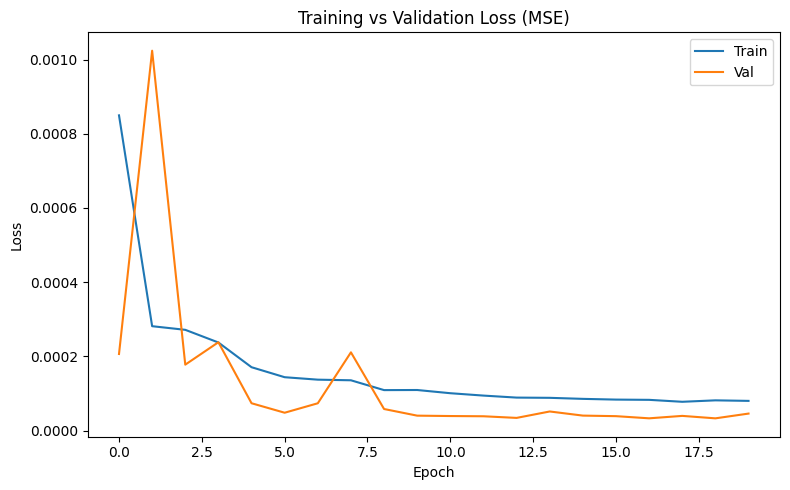

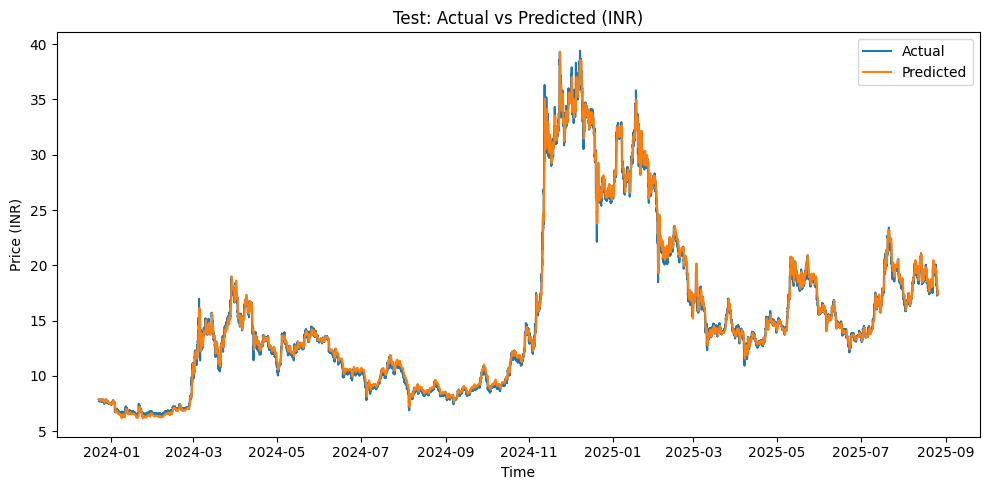

/var/folders/7z/lym9xm5d691_v7b014fc_tvm0000gn/T/ipykernel_59435/2484689403.py:111: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_times = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=FORECAST_STEPS, freq="H")


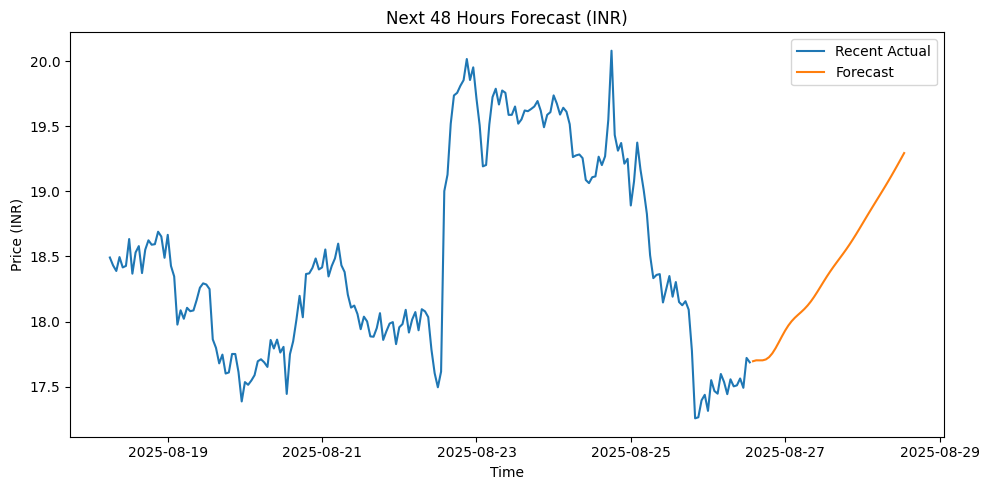

In [6]:
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- CONFIG ---
CSV_PATH = "/Users/vanshagarwal/Documents/GitHub/ML-Driven-Web-Platform-for-Cryptocurrency-Price-Forecasting_August_2025/Milestone1/crypto hourly data/DOGE_USD_historical_hourly.csv"   # replace with your file path
RATE_INR_PER_USD = 83.0
LOOKBACK = 96
FORECAST_STEPS = 48
np.random.seed(42); tf.random.set_seed(42)

# --- Load/Preprocess ---
df = pd.read_csv(CSV_PATH)
df["timestamp"] = pd.to_datetime(df["TIMESTAMP"], unit="s", utc=True)
df = df.sort_values("timestamp").set_index("timestamp").asfreq("H")
df["close_usd"] = df["CLOSE"].interpolate(method="time").ffill().bfill()
df["close_inr"] = df["close_usd"] * RATE_INR_PER_USD
values = df[["close_inr"]].values.astype("float32")

# scale 0–1
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# make sequences
X, y = [], []
for i in range(len(scaled) - LOOKBACK):
    X.append(scaled[i:i+LOOKBACK, 0])
    y.append(scaled[i+LOOKBACK, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# chronological split (70% train, 15% val, 15% test)
n = len(X); n_test = int(0.15*n); n_val = int(0.15*n); n_train = n - n_val - n_test
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]
t = df.index.values[LOOKBACK:]
t_test = t[n_train+n_val:]

# --- Model ---
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK,1),
         kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.3),
    LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
 
    Dropout(0.4),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

# callbacks
coin = "DOGE"      # e.g. SOL, BTC, ETH
interval = "1h" 
ckpt = f"{coin.lower()}_{'hourly' if interval=='1h' else 'daily'}_lstm.keras"
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    ModelCheckpoint(ckpt, monitor="val_loss", save_best_only=True)
]

# --- Train ---
hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,       # smaller batch size
    verbose=1,
    callbacks=callbacks
)


# --- Evaluate ---
pred_test_scaled = model.predict(X_test, verbose=0)
pred_test = scaler.inverse_transform(pred_test_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

mae = mean_absolute_error(y_test_actual, pred_test)
rmse = math.sqrt(mean_squared_error(y_test_actual, pred_test))
mape = np.mean(np.abs((y_test_actual - pred_test) / np.maximum(y_test_actual,1e-8))) * 100
r2 = r2_score(y_test_actual, pred_test)
print(f"MAE ₹{mae:.2f} | RMSE ₹{rmse:.2f} | MAPE {mape:.2f}% | R² {r2:.4f}")

# --- Loss curve ---
plt.figure(figsize=(8,5))
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Val")
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

# --- Actual vs Predicted ---
plt.figure(figsize=(10,5))
plt.plot(t_test, y_test_actual.flatten(), label="Actual")
plt.plot(t_test, pred_test.flatten(), label="Predicted")
plt.title("Test: Actual vs Predicted (INR)")
plt.xlabel("Time"); plt.ylabel("Price (INR)"); plt.legend(); plt.tight_layout(); plt.show()

# --- Forecast 48 hours ---
last_window = scaled[-LOOKBACK:].copy().reshape(1,LOOKBACK,1)
future_scaled = []
for _ in range(FORECAST_STEPS):
    nxt = model.predict(last_window, verbose=0)[0,0]
    future_scaled.append(nxt)
    last_window = np.concatenate([last_window[:,1:,:], nxt.reshape(1,1,1)], axis=1)
future = scaler.inverse_transform(np.array(future_scaled).reshape(-1,1)).flatten()
future_times = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=FORECAST_STEPS, freq="H")

plt.figure(figsize=(10,5))
plt.plot(df.index[-200:], df["close_inr"].iloc[-200:], label="Recent Actual")
plt.plot(future_times, future, label="Forecast")
plt.title(f"Next {FORECAST_STEPS} Hours Forecast (INR)")
plt.xlabel("Time"); plt.ylabel("Price (INR)")
plt.legend(); plt.tight_layout(); plt.show()
